# Tarea Individual Módulo 6 - Parte 1

_En algunas celdas de este notebook se pide escribir código para ciertas tareas. En esta celda se muestra un pequeño ejemplo._

__Ejemplo:__
````
### 0. Escribir código para asignar el valor 1 a una variable.###
### Sustituir None por el código necesario ###
a = None
`````
__Solución:__
````
### 0. Escribir código para asignar el valor 1 a una variable.###
### Sustituir None por el código necesario ###
a = 1
`````
_______

El entorno virtual de Google Colab tiene instaladas la mayoría de las librerías
que se suelen utilizar en problemas de IA. Sin embargo, necesitamos instalar la
librería transformers de Huggingface y la librería tqdm que es una librería que nos permite mostrar una barra de progreso cuando utlizamos bucles for.

In [ ]:
!pip install transformers
!pip install tqdm

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 44.2 MB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 3.3 MB 33.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# 0. Imports

En la sección `Imports` agrupamos todas las librerías y clases que debemos importar en esta tarea.

In [ ]:
# import basic libraries for data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import torch and transformers
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# import different metrics for evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score

# import tqdm to track progress
from tqdm import tqdm

# import some python modules required for some of the utility functions
import itertools
import re

# 1. Utils

En la sección `Utils` se encuentran varias funciones de utilidad con sus docstrings que se utilizarán a largo de la implementación para preprocesar y limpiar datos y también evaluar los resultados.

Aquí encontrais la función `text_cleaning()` sobre la que teneis que responder unas preguntas.

In [ ]:
################################
# text processing and cleaning #
################################

def encode_sentiment(sentiment):
  """
  Label encode sentiment.

  Parameters
  ----------
  sentiment: str, sentiment {"positive", "sentiment"}

  Returns
  -------
  int, 1's for positive and 0's for negative

  """
  if sentiment == "positive":
    return 1
  else:
    return 0

def is_ascii(w):
  """
  Check if character is ascii type.

  Parameters
  ----------
  w: str, character

  Returns
  -------
  bool, True if character is ascii. False otherwise.
  """
  try:
    w.encode("ascii")
    return True
  except UnicodeEncodeError:
    return False

def text_cleaning(text):
  """
  Clean text from symbols, punctuation, etc.

  Parameters
  ----------
  text: string, text data
  
  Returns
  -------
  cleaned_text: string, cleaned text data
  """
  # remove string formatting '\n' or '\t'
  tmp_text = re.sub(r'\n+', '. ', text)
  tmp_text = re.sub(r'\t+', '. ', text)
  # remove words with non-ascii characters
  tmp_text = " ".join([word for word in tmp_text.split() if is_ascii(word)])
  # remove email address
  tmp_text = " ".join([word for word in tmp_text.split() if not word.startswith("@")])
  # remove urls
  tmp_text = re.sub(r'http\S+', '', tmp_text, flags=re.MULTILINE)
  tmp_text = re.sub(r'www\S+', '', tmp_text, flags=re.MULTILINE)
  # remove punctuation but . (to split sentences)
  cleaned_text = re.sub('[^A-Za-z.,]+', ' ', tmp_text)
  # lowercase
  cleaned_text = cleaned_text.lower()

  return cleaned_text

##############
# Evaluation #
##############

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# 2. Config

En la sección `Config` definimos variables y objetos que utilizaremos en el desarrollo y queremos tener agrupados en el mismo lugar.

In [ ]:
# Defining some key variables that will be used later on
MAX_LEN = 512 # max number of tokens
BATCH_SIZE = 64
SEED = 42 # for reprodudible results

# Initialiaze model tokenizer
TOKENIZER = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Setting up the device for GPU usage if available
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print(DEVICE)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

cuda


# 3. Data

En la sección `Data` necesitamos cargar los datos en un dataframe de pandas, codificar el sentimiento y limpiar el texto.

Podeis hacer uso de las funciones de utilidad `encode_sentiment()` y `text_cleaning()`.

In [ ]:
### 1. Escribir código para cargar los datos y codificar la columna sentiment.###
### Sustituir None por el código necesario ###
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
raw_data = pd.read_csv('/content/drive/My Drive/MasterIADeporte/Modulo6_BERT/IMDB_Dataset.csv')
raw_data['sentiment'] = raw_data['sentiment'].apply(lambda row: encode_sentiment(row))
raw_data.head()

Mounted at /content/drive


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
### 2. Escribir código para limpiar el texto utilizando la función text_cleaning() ###
### Sustituir None por el código necesario ###
cleaned_data = raw_data.copy()
cleaned_data["review"] = cleaned_data["review"].apply(lambda row: text_cleaning(row))
cleaned_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. br br the filmi...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


# 4. Dataset and Dataloader

En la sección `Dataset and Dataloader` vamos a crear un dataset de Pytorch del tipo map-iterable que utilizaremos para almacenar los datos y procesarlos de acuerdo a los requirimientos del modelo.

Después creamos un objeto `DataLoader` de Pytorch que toma el dataset para poder pasar ejemplos al modelo en lotes o batches.

__Clase DistilBertDataset__

La clase `DistilBertDataset` toma como argumentos un dataframe con los datos, el tokenizador del modelo y el número de máximo de tokens que definimos en la sección `Config`.

El método `__getitem__()` toma como parámetro un índice de los datos en el dataset, extrae el ejemplo correspondiente del dataframe y utiliza la función `encode_plus()` del tokenizador para procesar los inputs de acuerdo a los requerimientos de DistilBERT ( special tokens [CLS] y [SEP], truncation, padding, etc.). Este método devuelve un diccionario de python con los tensores que continen los inputs ids, los attention masks y el sentimiento codificado.

El método `__len__()` simplemente devuelve el número de ejemplos en el dataset.

__DataLoader__

El `DataLoader` viene a ser un generador que devulve lotes de tamaño `BATCH_SIZE` para alimentar el modelo.

En sus parámetros podemos definir el tamaño de lote o batch size, si seleccionar de forma aleatoria los ejemplos a incluir en el batch o no (recomendable al realizar un entrenamiento) y también el número de workers a utilizar (2 para Google Colab).

In [ ]:
class DistilBertDataset(Dataset):
  """Custom pytorch map-iterable dataset for sentiment analysis with DistilBERT."""
  def __init__(self, dataframe, tokenizer, max_len):
      self.len = len(dataframe)
      self.data = dataframe
      self.tokenizer = tokenizer
      self.max_len = max_len

  def __getitem__(self, index):
      text = str(self.data['review'].loc[index])
      text = " ".join(text.split())
      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=False,
          truncation=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      
      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'targets': torch.tensor(self.data['sentiment'].loc[index], dtype=torch.long)
      }

  def __len__(self):
      return self.len

In [ ]:
### 3. Escribir código para crear un objeto DistilBertDataset con los inputs ###
### limpios, el tokenizador del modelo y el máximo número de tokens ###
### Sustituir None por el código necesario ###
dataset = DistilBertDataset(cleaned_data, TOKENIZER, MAX_LEN)

In [ ]:
print("---- Visually inspecting 5th element ----")
print(f"Input ids: {dataset[6]['ids']}")
print(f"Attention masks: {dataset[6]['mask']}")
print(f"Target: {dataset[6]['targets']}")
print("------------------------------------------")

---- Visually inspecting 5th element ----
Input ids: tensor([  101,  1045,  2469,  2052,  2066,  2000,  2156,  1037, 15218,  1997,
         1037,  2039,  6052,  2712, 17157,  2102,  2186,  2007,  1996,  6627,
         2027,  2031,  2651,  2009,  2052,  3288,  2067,  1996,  4845,  8277,
         1999,  2033,  1012,  1045,  3473,  2039,  2006,  2304,  1998,  2317,
         2694,  1998,  2712, 17157,  2102,  2007,  4409,  5302,  3489,  2020,
         2026,  5394,  1055,  2296,  2733,  1012,  2017,  2031,  2026,  3789,
         2005,  1037, 12845,  1997,  1037,  2047,  2712,  5690,  1012,  2057,
         2342,  1037,  2689,  1997,  6393,  1999,  2694,  1998,  2023,  2052,
         2147,  2005,  1037,  2088,  1997,  2104,  2300,  6172,  1012,  2821,
         2011,  1996,  2126,  4067,  2017,  2005,  2019, 13307,  2066,  2023,
         2000,  3193,  2116, 21386,  2015,  2055,  2694,  1998,  1996,  2116,
         5691,  1012,  2061,  2151, 15589,  2126,  1045,  2903,  1045,  2310,
         22

In [ ]:
# define dataloader params
dataloader_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 2
                }

# create dataloader
data_loader = DataLoader(dataset, **dataloader_params)

# 5. Model

En la sección `Model` creamos la clase DistilBERTClass() con el modelo ya ajustado que se encuentra en el hub de modelos de Huggingface.

El método `forward()` de la clase toma los inputs ids y attention mask que devuelve el método `__getitem__()` de la clase `DistilBertDataset`.

In [ ]:
class DistilBERTClass(torch.nn.Module):
  """Custom class for DilstilBERT model for Sequence Classification."""
  def __init__(self):
      super(DistilBERTClass, self).__init__()
      self.model = AutoModelForSequenceClassification \
        .from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

  def forward(self, input_ids, attention_mask):
      output = self.model(input_ids=input_ids, attention_mask=attention_mask) 
      logits = output.logits
      
      return logits

# 6. Inference

En la sección `Inference` vamos a utilizar el modelo para realizar inferencia y obtener los sentimientos de las reviews.

Después utilizamos la función `inference()` para obtener las predicciones.


In [ ]:
# Download and load trained DistilBERT model
model = DistilBERTClass()
model.to(DEVICE)

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

DistilBERTClass(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn):

In [ ]:
def inference(data_loader, model, device):
    """
    Binary classification using DistilBERT model.

    Parameters
    ----------
    data_loader: Pytorch DataLoader object
    model: DistilBERTClass Object
    device: str, device

    Returns
    -------
    lists, outputs logits and targets
    """
    # put model in evaluation mode
    model.eval()
    # create lists to be populated with predictions and corresponding targets
    fin_targets = []
    fin_outputs = []
    # do not calculate gradients as not required for inference
    with torch.no_grad():
        # loop over batches and get predictions
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            targets = d['targets']

            # send them to the cuda device we are using
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)
            # get outputs logits
            outputs = model(
                input_ids=ids,
                attention_mask=mask
            )
            # Normalize logits and store results and targets in lists
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

In [ ]:
# run inference -> sentiment analysis
out_pred, targets = inference(
    data_loader=data_loader,
    model=model,
    device=DEVICE
)

100%|██████████| 782/782 [28:12<00:00,  2.16s/it]


In [ ]:
### 4. Escribir código obtener las predicciónes a partir de las logits normalizadas ###
### Criterio: Elegir la clase más probable ###
### La función de numpy np.argmax() puede ser de gran ayuda ;) ###
### Sustituir None por el código necesario ###
outputs = np.argmax(out_pred, axis=1)

# 7. Evaluation

En la sección `Evaluation` calculamos métricas típicas de un poblema de clasificación binario: Accuracy y F1 Score.

También graficamos la matriz de confusión utlizando la función de utilidad `plot_confusion_matrix()`.

Finalmente, hacemos una pequeña evaluación visual de los inputs, los targets y las predicciones.

In [ ]:
### 5. Escribir código para calcular accuracy y f1_score ###
### Sustituir None por el código necesario ###
accuracy = accuracy_score(targets, outputs)
f_score = f1_score(targets, outputs, average='macro')
print(f"Training Accuracy Score = {accuracy}")
print(f"Training F1-Score = {f_score}")

Training Accuracy Score = 0.88854
Training F1-Score = 0.8884356721360729


In [ ]:
# classification report
print(classification_report(targets, outputs, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.87      0.92      0.89     25000
    Positive       0.91      0.86      0.89     25000

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000



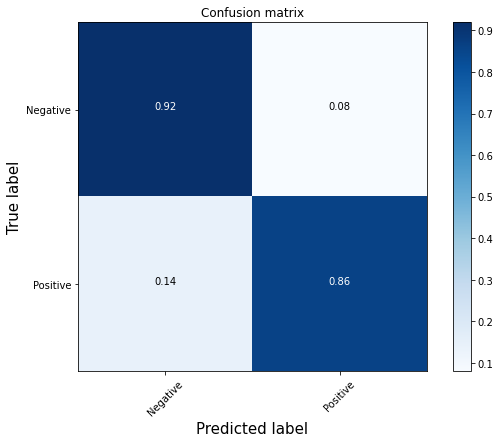

In [ ]:
# print the confusion matrix
cnf_matrix = confusion_matrix(targets, outputs, labels=[0, 1])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,classes=['Negative','Positive'],
    normalize=True,
    title='Confusion matrix'
)

In [ ]:
#visual evalution
for review, target, output in zip(cleaned_data.review.values[:10], targets, outputs):
  print(f"Text: {review}")
  print(f"Target: {target}\tOutput: {output}\n")

Text: one of the other reviewers has mentioned that after watching just oz episode you ll be hooked. they are right, as this is exactly what happened with me. br br the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. br br it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. br br i would say the main appeal of the show is due to the fact that it g

# 8. Preguntas

### 8.1. La función `text_cleaning` se utiliza para limpiar el texto de caracteres, puntuación, etc. que añaden ruido a los datos y dificultan el aprendizaje. ¿Cuál crees que ha sido el proceso para identificar los requerimientos de limpieza de los datos y que se ven reflejados es esta función? ¿Crees que se podría mejorar esta función?

### Respuesta: 
###En cuanto a la primera pregunta, el principal objetivo del preprocesamiento aplicado en la función text_cleaning es el de la eliminación del formato adyacente al texto que se muestra. Borramos HTML tags, URL's, direcciones de correo electrónico, caracteres especiales (no ASCII), convertimos todas las palabras a minúsculas y borramos todos los signos de puntuación excepto el punto.
### En cuanto a la segunda pregunta, hay mucha literatura al respecto en la que se detalla como preprocesar un texto. Como líneas generales, se podrían aplicar los siguientes pasos: expandir contracciones (you're --> you are), convertir palabras que hacen referencia a números en números y borrarlos, borrar las 'stopwords', hacer 'lemmatization'/'stemming', hacer un análisis por frecuencia del texto y borrar aquellas palabras que aparezcan pocas ocasiones (outliers/palabras atípicas) o incluso normalizar expresiones que puedan escribirse de varias maneras (FYI/For your information).

### 8.2. En la plantilla, ¿Cuál es el propósito de la siguiente línea de código?

`model.to(DEVICE)`

### Respuesta:
### Cargar nuestro modelo al dispositivo correspondiente sobre el cual vamos a ejecutar nuestro entrenamiento, ya sea CPU o GPU.